# Bank marketing

**1. Project description**
+ **1.1 Goal**
+ **1.2 Data**
+ **1.3 Data provider**
+ **1.4 Software**

**2. Exploratory Data Analysis** 
+ **2.1 Loading the dataset**
+ **2.2 Missing values**
+ **2.3 Data types**
+ **2.4 Feature importance and analysis of target variable.**
+ **2.5 Doing the train/validation/test split**
+ **2.6 Encoding the categorical variables**
+ **2.7 Scaling**

**3. Model training** 
+ **3.1 Metric selection**
+ **3.2 Logistic Regression**
+ **3.3 Decision Tree**
+ **3.4 Random Forest**
+ **3.5 XGBoost**
+ **3.6 Model selection**

**4. Exporting the notebook to a python script**

## 1. Project description

### 1.1 Goal

The classification goal is to predict if the bank client will subscribe (yes/no) a fix term deposit (target variable 'deposit') after a marketing campaign. It might help the bank in designing promotions, new campaigns, and understanding controversial campaign results.

### 1.2 Data

###### Bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'primary', 'secondary', 'terciary','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- balance: not in the original data set, probably how much money the client has in the bank
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
- contact: contact communication type (categorical: 'cellular','telephone','unknown)
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

###### Campaign-related attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; '-1' means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

###### Output variable (desired target):
- deposit - has the client subscribed a term deposit? (binary: 'yes','no')

### 1.3 Data provider

Original dataset: [UCI Machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing)

Here we use a subset of the dataset dowloaded from [Kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset). There are some minor differences:
+ this Kaggle dataset is balanced (in the Discussion tab at the Kaggle webpage in the link it is said that the resampling was probably done by bootstrapping). 
+ the variable 'education' has been simplified in the Kaggle dataset to 'primary', 'secondary', 'terciary', and 'unknown', the original values were: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown'.
+ in the Kaggle dataset the variable 'pdays' takes the value '-1' (instead of '999' as in the original dataset) when the client was not previously contacted.
+ the Kaggle dataset has a column named 'balance' and does not have the 'Social and economic context attributes' (like euribor 3 moth rate) shown in the original dataset.

Citation: _A Data-Driven Approach to Predict the Success of Bank Telemarketing._ S. Moro, P. Cortez and P. Rita. Decision Support Systems, Elsevier, 62:22-31, June 2014

### 1.4 Software

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display

%matplotlib inline

## 2. Exploratory Data Analysis    

### 2.1 Loading the dataset

In [2]:
path = "/home/mmc/Desktop/DataTalks/mid_term_project/"  
df = pd.read_csv(path + "bank.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


### 2.2 Missing values

In [3]:
max(df.isnull().sum())

0

There are not missing values in the dataset but many values are 'unknown'. We checked that the model performance is fine by having 'unknown' as a value. The model decision power might be reduced (i.e., predictions involving variables with 'unknown' values might not be very informative, see the Decision Tree Classifier section), however we prefer to do not replace these values by NaN or zeros.

In [4]:
df[df == 'unknown'].count()

age             0
job            70
marital         0
education     497
default         0
balance         0
housing         0
loan            0
contact      2346
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     8326
deposit         0
dtype: int64

### 2.3 Data types

In [5]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

Some categorical variables can easily be converted to numeric for the EDA:

In [6]:
# Replace with numbers 0 (negative or 'no') and 1 (positive or 'yes')
df.default = (df.default == 'yes').astype(int)
df.loan = (df.loan == 'yes').astype(int)
df.housing = (df.housing == 'yes').astype(int)
df.deposit = (df.deposit == 'yes').astype(int)

In [7]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(include=['int64']).columns.tolist()

### 2.4 Feature importance

To identify which features affect the target variable 'deposit'.

##### Numerical variables

##### A. Range of values and basic stats

In [8]:
df.describe().round(2)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit
count,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00,11162.00
mean,41.23,0.02,1528.54,0.47,0.13,15.66,371.99,2.51,51.33,0.83,0.47
std,11.91,0.12,3225.41,0.50,0.34,8.42,347.13,2.72,108.76,2.29,0.50
min,18.00,0.00,-6847.00,0.00,0.00,1.00,2.00,1.00,-1.00,0.00,0.00
25%,32.00,0.00,122.00,0.00,0.00,8.00,138.00,1.00,-1.00,0.00,0.00
50%,39.00,0.00,550.00,0.00,0.00,15.00,255.00,2.00,-1.00,0.00,0.00
75%,49.00,0.00,1708.00,1.00,0.00,22.00,496.00,3.00,20.75,1.00,1.00
max,95.00,1.00,81204.00,1.00,1.00,31.00,3881.00,63.00,854.00,58.00,1.00


Different columns show very different range of values, we will need to scale (see below, after the data split).

##### B. Pair plots

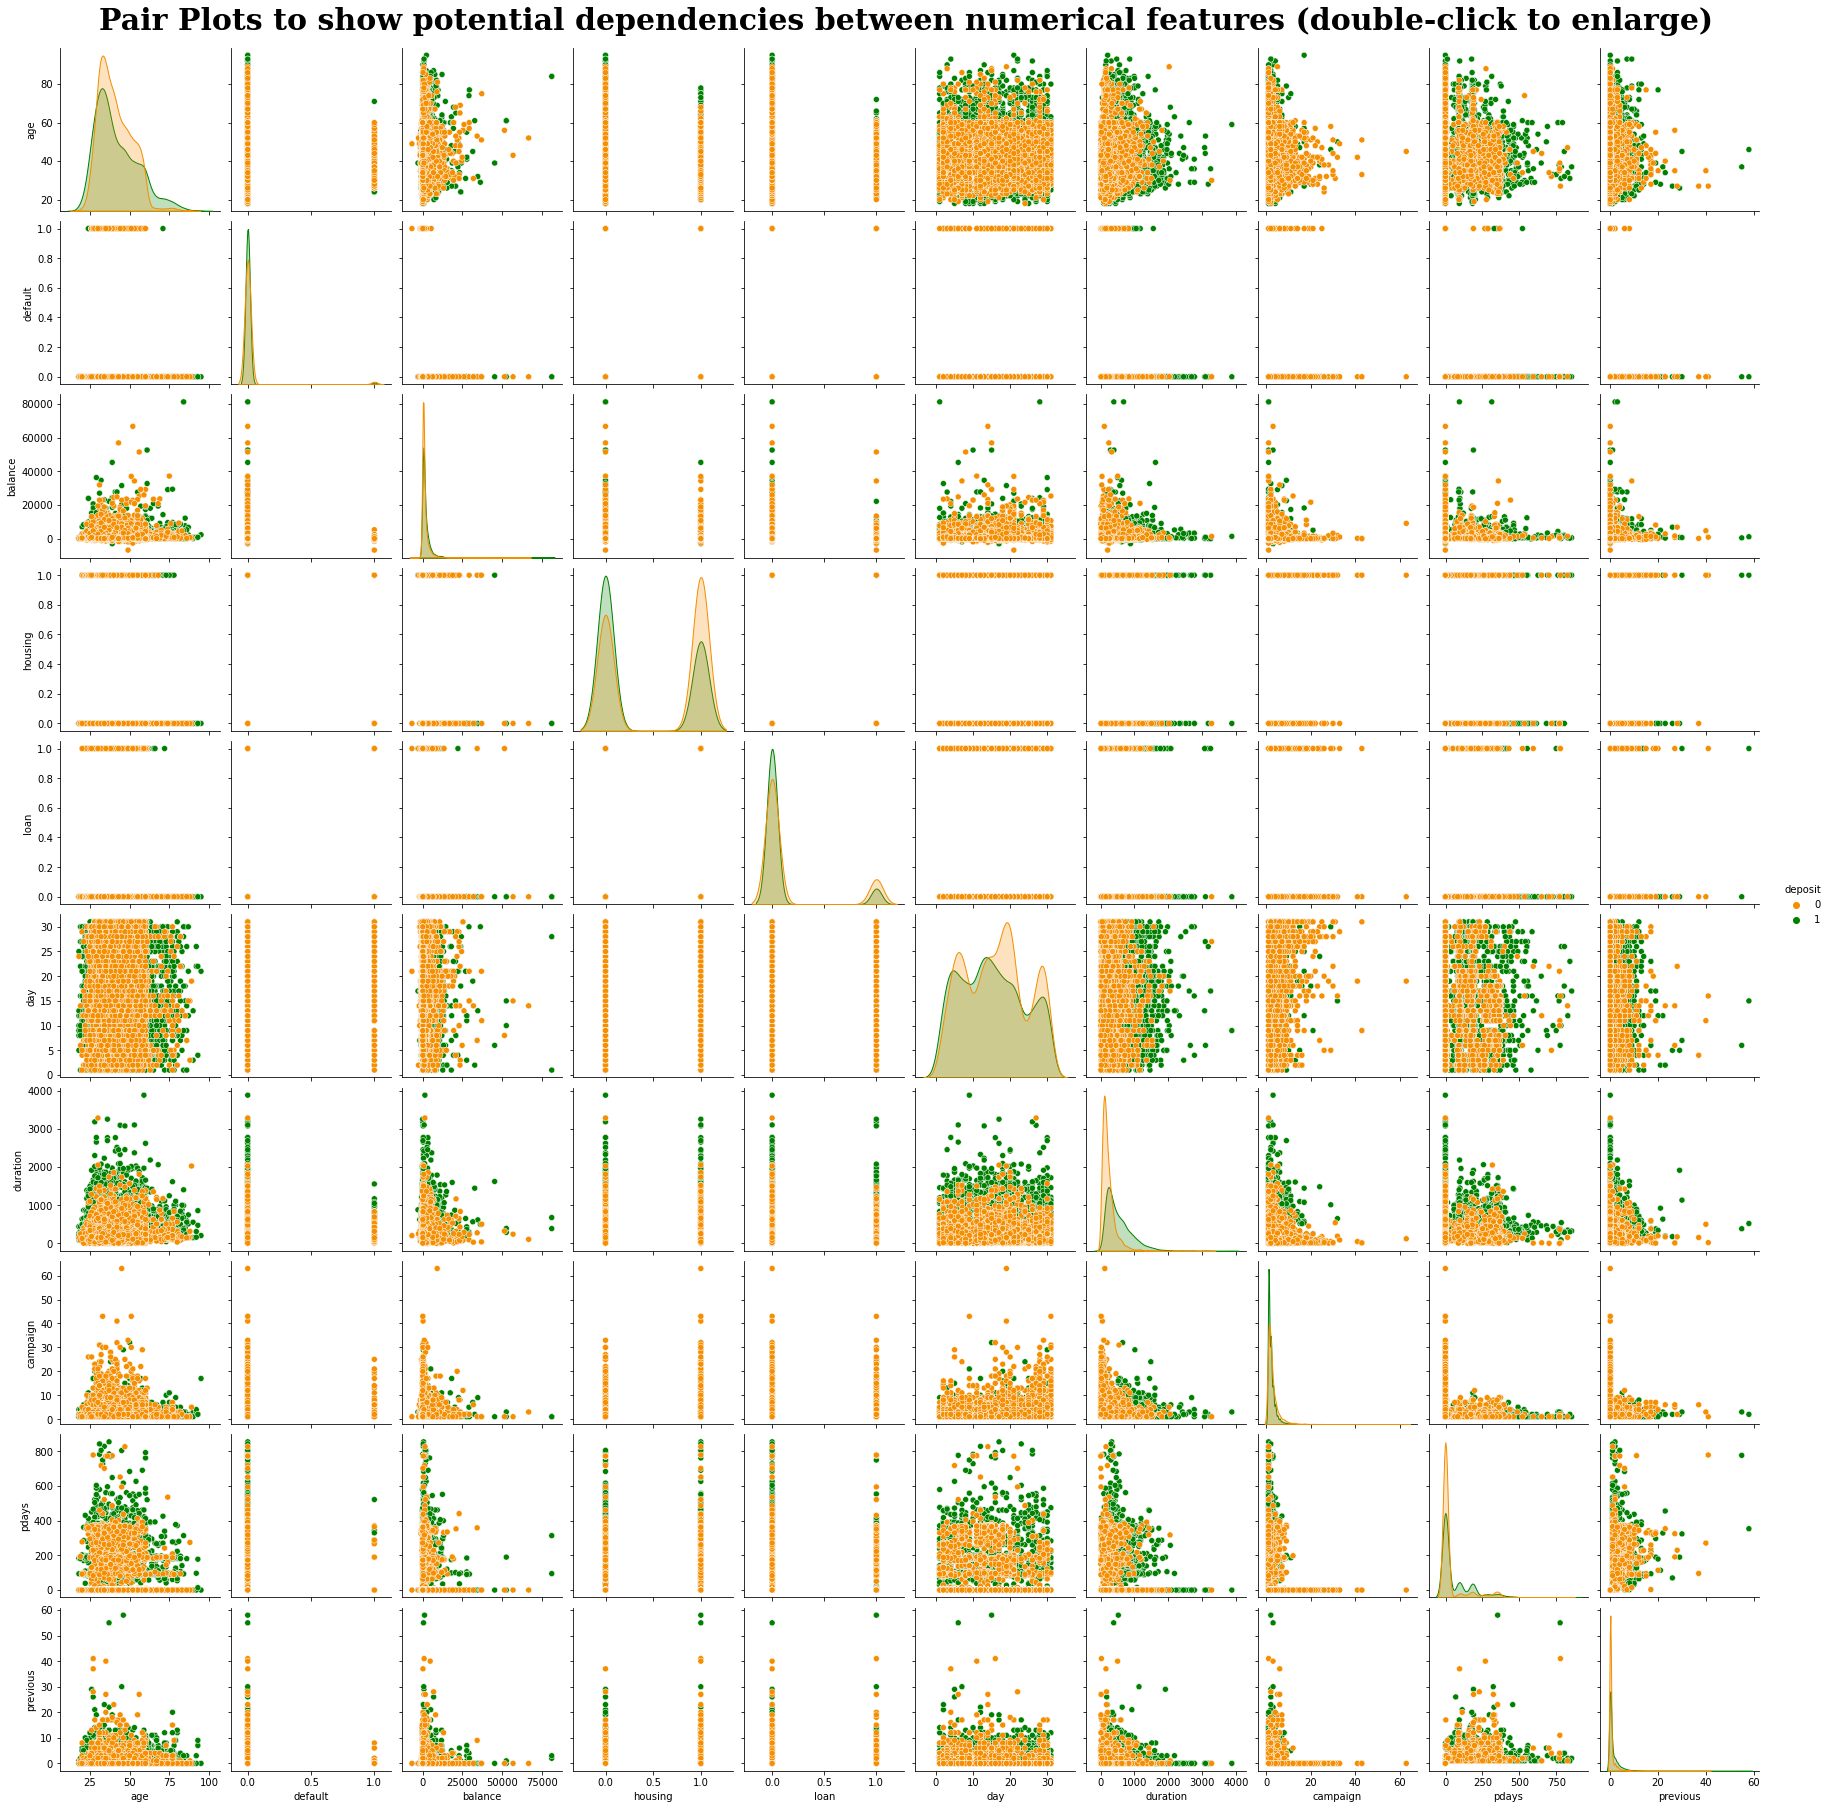

In [9]:
# This visualization takes a while, set the if as "True" to run it
if True:#False: 
    colors = ["#f58e00", "g"]
    labels = "No", "Yes"
    hue_order = [0, 1]

    ax = sns.pairplot(df, hue='deposit', palette=colors, hue_order=hue_order)
    ax.fig.suptitle('Pair Plots to show potential dependencies between numerical features (double-click to enlarge)',
                family='Serif', size=30, ha='center', weight='bold', y = 1.01)
    plt.show()

The pair plots do not show obvious dependencies.

##### C. Frequency distribution

The diagonal of the pair plots above show the frequency distribution of the numerical features. The target variable 'deposit' is quite balanced:

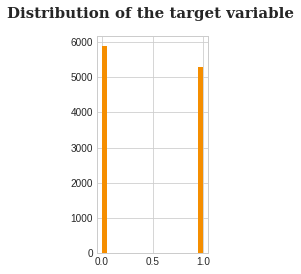

In [10]:
plt.style.use('seaborn-whitegrid')
df.deposit.hist(bins=20, figsize=(2,4), color="#f58e00")
plt.suptitle('Distribution of the target variable', family = 'Serif', 
             size = 15,weight = 'bold')
plt.show()

In [11]:
df.deposit.value_counts(normalize=True) 

0    0.52616
1    0.47384
Name: deposit, dtype: float64

##### D. Correlation by the [Pearson coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [12]:
matrix_corr = df.corr().round(3)

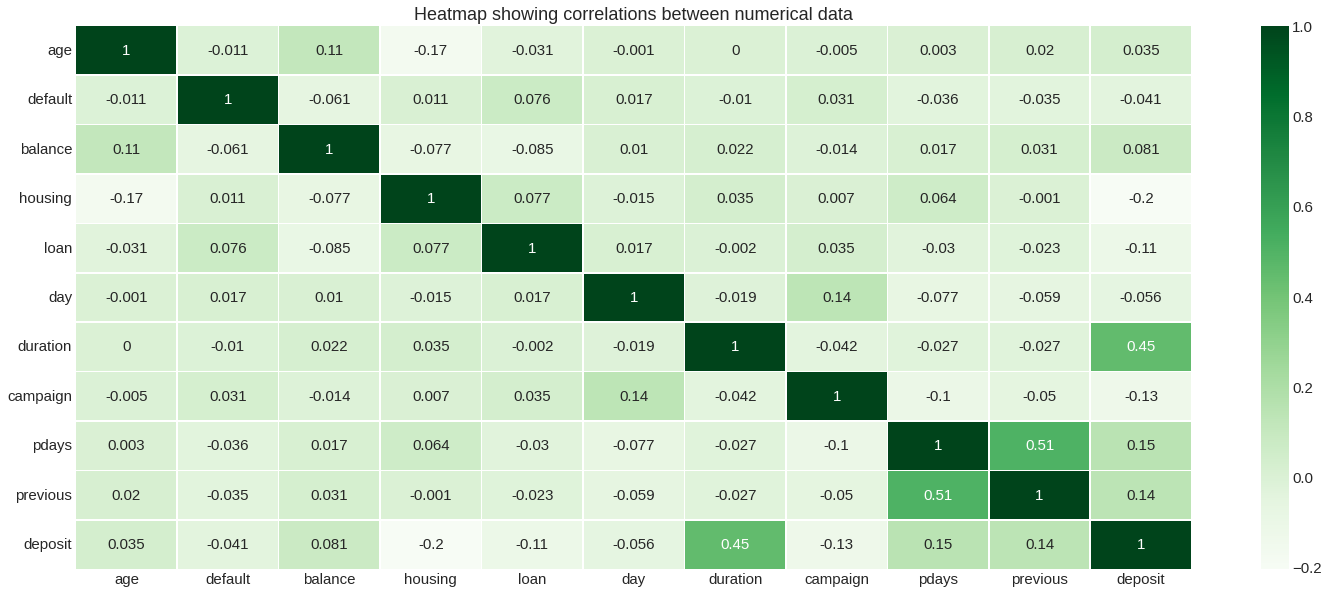

In [13]:
plt.figure(figsize=(25,10))
plt.rc('font', size=15) 
sns.heatmap(matrix_corr,annot=True,linewidths=.5, cmap="Greens")
plt.title('Heatmap showing correlations between numerical data')
plt.show() 

The feature 'duration', i.e., the duration of the last contact, shows the higher correlation with the target deposit. However, as mentioned in the data provider section above, it might be because if 'duration'=0 then 'deposit'='no', and the call duration is not known before a call is performed. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model (see the section Model Selection of a comparison of the results including and not including this feature).

Apart from 'duration', the next highest correlations in the numerical features are a positve correlation with 'pdays' (days from last contact) and 'previous' (contacts before this campaign) and negative correlations with 'housing', 'campaign' (contacts in this campaign) and 'loan' (people with loans might not engage to the fix term deposit).

##### E. ROC AUC for feature importance

The [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is the probability that a randomly selected positive example (someone that will agree to open a fix term deposit) has a higher score (higher probability to be predicted as positive or higher feature value if, like here, we want to use ROC AUC for feature important), than a randomly selected negative example (someone that will not open a fix term deposit).

In [14]:
feature_scores = []

for col in numerical:       
    auc = roc_auc_score(df.deposit, df[col]) 
    if auc < 0.5: # in case the feature is negatively correlated with the target
        auc = roc_auc_score(df.deposit, -df[col]) 
    feature_scores.append((col, auc))

columns = ['feature', 'ROC_AUC']
df_scores = pd.DataFrame(feature_scores, columns=columns)
df_scores.sort_values(by=['ROC_AUC'],ascending=False).reset_index(drop = True)

,feature,ROC_AUC
0,deposit,1.000000
1,duration,0.805144
2,housing,0.601936
3,previous,0.601615
4,pdays,0.594122
5,balance,0.591091
6,campaign,0.569418
7,loan,0.537337
8,day,0.533697
9,age,0.507025


Again, apart from 'duration', that can be problematic, as the data provider mentioned above, the highest ROC AUC in the numerical features are 'housing', 'previous' (contacts before this campaign), and 'pdays' (days from last contact). Now also 'balance' shows relevance, even higher than 'loan' (people with loans might not engage to the fix term deposit) and 'campaign' (number of contacts in this campaign).

##### Categorical variables

##### A. Mean difference and risk ratio

In [15]:
for c in categorical:
    print(c)
    df_group = df.groupby(c).deposit.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - df.deposit.mean() # mean difference
    df_group['risk'] = df_group['mean'] / df.deposit.mean() # risk ratio
    display(df_group)
    print()

job


,mean,count,diff,risk
job,,,,
admin.,0.473013,1334,-0.000826,0.998256
blue-collar,0.364198,1944,-0.109642,0.768609
entrepreneur,0.375000,328,-0.098840,0.791407
housemaid,0.397810,274,-0.076030,0.839546
management,0.507015,2566,0.033175,1.070013
retired,0.663239,778,0.189399,1.399712
self-employed,0.461728,405,-0.012111,0.974440
services,0.399783,923,-0.074056,0.843710
student,0.747222,360,0.273382,1.576951



marital


,mean,count,diff,risk
marital,,,,
divorced,0.481052,1293,0.007212,1.015220
married,0.433790,6351,-0.040050,0.915478
single,0.543491,3518,0.069651,1.146992



education


,mean,count,diff,risk
education,,,,
primary,0.394000,1500,-0.079840,0.831505
secondary,0.447407,5476,-0.026433,0.944215
tertiary,0.541068,3689,0.067228,1.141880
unknown,0.507042,497,0.033202,1.070071



contact


,mean,count,diff,risk
contact,,,,
cellular,0.543273,8042,0.069433,1.146533
telephone,0.503876,774,0.030036,1.063389
unknown,0.225916,2346,-0.247923,0.476778



month


,mean,count,diff,risk
month,,,,
apr,0.625135,923,0.151296,1.319297
aug,0.452930,1519,-0.020910,0.955871
dec,0.909091,110,0.435251,1.918562
feb,0.568299,776,0.094459,1.199348
jan,0.412791,344,-0.061049,0.871161
jul,0.414135,1514,-0.059705,0.873997
jun,0.446809,1222,-0.027031,0.942953
mar,0.898551,276,0.424711,1.896317
may,0.327550,2824,-0.146290,0.691266



poutcome


,mean,count,diff,risk
poutcome,,,,
failure,0.503257,1228,0.029418,1.062083
other,0.571695,537,0.097855,1.206514
success,0.913165,1071,0.439325,1.927160
unknown,0.406678,8326,-0.067162,0.858260


It seems that 'month' (specially 'December' and 'March' with a risk ratio about 90% above average), 'job' (specially 'retired' and 'student') and previous outcome 'poutcome' (specially 'success') significatively affect if there is a deposit or not. The 'unknown' value of the feature 'contact' also shows an effect on the target variable, although this might not be very informative (low decision power).

##### B. Mutual Information

From [information theory](https://en.wikipedia.org/wiki/Mutual_information), for categorical variables, it tells us how much we can learn about one variable if we know the value of another.

In [16]:
def mut_inf_deposit_score(series):
    return mutual_info_score(series, df.deposit)

# apply the function column-wise
MutInf = df[categorical].apply(mut_inf_deposit_score)
MutInf.sort_values(ascending=False) # to sort it

poutcome     0.050386
month        0.050114
contact      0.034722
job          0.017244
education    0.005513
marital      0.004911
dtype: float64

##### Feature importance summary

The next highest correlations in the numerical features are a positive correlation with **'pdays'** (days from last contact) and **'previous'** (contacts before this campaign) and negative correlations with **'housing'** and **'loan'** (people with loans might not engage to the fix term deposit) and **'campaign'** (number of contacts in this campaign).

The previous outcome **'poutcome'**, **'contact'**, and **'job'**, seem to be the most relevant categorical features. 

We still use all of them (see the Model Selection section about the results if we dismiss 'duration', as suggested by the data provider) since 15 is a suitable number of features. So far, the 'unknown' values has not being converted to NaNs.

In [17]:
df_select = df.copy() 
#del df_select['duration']  
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64']).columns.tolist()
numerical.remove('deposit')

Uncomment the removal of the feature 'duration' to check how is performance without this feature, which is defined as problematic by the dat aprovider, see above. When uncommented, the final XGBoost ROC AUC in the Model selection section is ~0.787.

### 2.5 Doing the train/val/test split

In [18]:
# separate train + validation (= full) and test
df_full_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
# now split the full into train and val, it should be the 20% of the 80%, which is 20/80=1/4=0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) 
len(df_train), len(df_val), len(df_test)

(6696, 2233, 2233)

In [19]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# separate the target
y_train = df_train.deposit.values
y_val = df_val.deposit.values

# remove the target from the features
del df_train['deposit']
del df_val['deposit']


### 2.6 Encoding the categorical variables

We use Scikit-Learn DictVectorizer to encode categorical features (it takes a dictionary and convert it to a vector (numpy.array)). It is One-hot encoding (OHE) method to converts the categorical features in binary (it would not affect the numerical ones), in as much columns as values the categorical variable takes.

In [20]:
dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

# VAL
val_dict = df_val[categorical].to_dict(orient='records')
X_val_cat = dv.transform(val_dict)

### 2.7 Scaling the numerical variables

We use Scikit-Learn StandardScaler to scale the numerical features (otherwise columns with values in a higher range would have more representation and the model does not converge).

In [21]:
scaler = StandardScaler()

# TRAIN
X_train_num = df_train[numerical].values
X_train_num = scaler.fit_transform(X_train_num)

# VAL
X_val_num = df_val[numerical].values
X_val_num = scaler.transform(X_val_num)

We join the numerical and categorical matrices:

In [22]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])

# VAL
X_val = np.column_stack([X_val_num, X_val_cat])

## 3 Model training

### 3.1 Metric selection

As the target in the dataset is quite balanced, the performance metrics we will use are:
+ [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) i.e., the proportion of right predictions, and 
+ [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), as mentioned above, the probability that a randomly selected positive example (someone that will actually open a fix term deposit) has a higher score (higher probability to be predicted as positive or higher feature value if we want to use ROC AUC for feature important) than a randomly selected negative example (someone that will not open a fix term deposit).

### 3.2 Logistic Regression

A linear regression as we studied in school that applies a 'sigmoid' filter to the predictions thus the results are binary values.

In [23]:
LR = LogisticRegression(C=1.0, random_state=42) 
# solver='lbfgs' is the default solver in newer version of sklearn
# the smallest the C, the stronger the regularizations (oposite to alpha o r)

LR.fit(X_train, y_train)
y_pred = LR.predict_proba(X_val)[:, 1] # left col is neg deposit (0), right col is pos deposit (1)
  
thresholds = np.linspace(0, 1, 5)
LR_scores = []
print('thres', 'acc')

for t in thresholds: # above threshold the probability becomes 1, below, is zero
    acc = accuracy_score(y_val, y_pred >= t) # it compares the 0/1 in y_val with the False/True of y_pred>=t
    print('%.2f %.3f' % (t, acc))
    LR_scores.append(acc)

thres acc
0.00 0.502
0.25 0.806
0.50 0.811
0.75 0.743
1.00 0.498


Best threshold is t = 0.5. A dummy threshold, t=0, means that the model predicts that none of the clients make a fix term deposit, and it is correct 50% of the times since the data are quite balanced.

In [24]:
t = 0.5

# TRAIN
y_pred = LR.predict_proba(X_train)[:, 1]
acc = accuracy_score(y_train, y_pred >= t) 
auc = roc_auc_score(y_train, y_pred)
print('For the training dataset:','ACC:', acc.round(3), 'ROC AUC:', auc.round(3))

# VAL
y_pred = LR.predict_proba(X_val)[:, 1]
LR_acc = accuracy_score(y_val, y_pred >= t) 
LR_auc = roc_auc_score(y_val, y_pred)
print('For the validation dataset:','ACC:', LR_acc.round(3), 'ROC AUC:', LR_auc.round(3))

For the training dataset: ACC: 0.829 ROC AUC: 0.908
For the validation dataset: ACC: 0.811 ROC AUC: 0.893


The performances of the model on the training and validation datasets are similar, thus there is not so much overfitting. The scores are good. Instead of tuning the parameters of the logistic regresion, let us try to improve the performance with non linear models.

### 3.3 Decision Tree Classifier

Decision trees learn if-then-else rules from data where finding the best split (true or false in the condition) means to select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group. Let us find the best threshold to calculate the accuracy (as we did for the Logistic Regression model), then we tune the tree parameters.

In [25]:
DT = DecisionTreeClassifier(max_depth = 6, random_state=1)
DT.fit(X_train, y_train)

y_pred = DT.predict_proba(X_val)[:, 1] # left col is neg deposit (0), right col is pos deposit (1)
  
thresholds = np.linspace(0, 1, 5)
DT_scores =[]
print('thres', 'acc')

for t in thresholds: # above threshold the probability becomes 1, below, is zero
    score = accuracy_score(y_val, y_pred >= t) # it compares the 0/1 in y_val with the False/True of y_pred>=t
    print('%.2f %.3f' % (t, score))
    DT_scores.append(score)
    
print('the ROC AUC is', roc_auc_score(y_val, y_pred).round(3))

thres acc
0.00 0.502
0.25 0.755
0.50 0.807
0.75 0.729
1.00 0.499
the ROC AUC is 0.864


Threshold t=0.5 seems to be the optimal choice again, thus we will just use it from now on. Let us find the best parameters for the decison tree classifier.

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

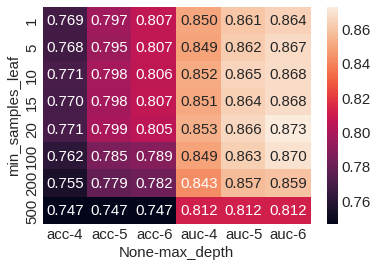

In [26]:
DT_scores = []
t = 0.5

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        DT = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state = 1)
        DT.fit(X_train, y_train)

        y_pred = DT.predict_proba(X_val)[:, 1]
        acc = accuracy_score(y_val, y_pred >= t) 
        auc = roc_auc_score(y_val, y_pred)
        
        DT_scores.append((depth, s, acc, auc))
        
columns = ['max_depth', 'min_samples_leaf', 'acc','auc']
df_scores = pd.DataFrame(DT_scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['acc','auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

It seems that max_depth=6 and min_samples_leaf=5 are good enought (the performance on the training and the validation data should not be too apart or the model will overfit and not generalize well for the final test dataset).

In [27]:
t = 0.5
DT = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state =1)
DT.fit(X_train, y_train)

# TRAIN
y_pred = DT.predict_proba(X_train)[:, 1]
acc = accuracy_score(y_train, y_pred >= t) 
auc = roc_auc_score(y_train, y_pred)
print('For the training dataset:','ACC:', acc.round(3), 'ROC AUC:', auc.round(3))

# VAL
y_pred = DT.predict_proba(X_val)[:, 1]
DT_acc = accuracy_score(y_val, y_pred >= t) 
DT_auc = roc_auc_score(y_val, y_pred)
print('For the validation dataset:','ACC:', DT_acc.round(3), 'ROC AUC:', DT_auc.round(3))

For the training dataset: ACC: 0.832 ROC AUC: 0.901
For the validation dataset: ACC: 0.807 ROC AUC: 0.867


The performances on the training and validation datasets are similar, there is not overfitting. 
Let us see how the leafs and branches look like:

In [28]:
print(export_text(DT, feature_names=numerical + dv.get_feature_names()))

|--- duration <= -0.48
|   |--- poutcome=success <= 0.50
|   |   |--- month=mar <= 0.50
|   |   |   |--- duration <= -0.74
|   |   |   |   |--- month=feb <= 0.50
|   |   |   |   |   |--- month=oct <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- month=oct >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- month=feb >  0.50
|   |   |   |   |   |--- day <= -0.73
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- day >  -0.73
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- duration >  -0.74
|   |   |   |   |--- housing <= 0.04
|   |   |   |   |   |--- month=apr <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- month=apr >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- housing >  0.04
|   |   |   |   |   |--- month=oct <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- month=oct >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |--- month=mar >  0.50
|   |   |   |--- age 

/home/mmc/miniconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Apart from **'duration'** (which according to the data provider could be problematic, see the notebook intro), it seems that the features with more decision power in the tree are:
+ **'poutcome'**, i.e. if the previous campaign worked with this client or not, it also showed a high feature importance in the EDA section (although it can be not informative since there are many 'unknown' values),
+ **'contact'**, i.e., how was the cliented contacted (although it can be not informative since there are many 'unknown' values), and 
+ **'campaign'**, i.e., how many times the client was contacted during the campaign, it showed some (negative) correlation with the target in the EDA, and there are not 'unknown' values, it seems to be an important tree branch with high prediction power in combination with 'pdays'. 

Surprisingly, **'housing'** showed higher correlation with 'deposit' and higher ROC AUC than 'campaign', but here it seems to be as relevant as **'month'** (some 'month' values showed a very high risk ratio in the EDA).

### 3.4 Random Forest

Let us go for ensemble learning and run in parallel many trees and take the average result. Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions (although here we will not explore the 'bootstrap' option). First we find the best parameters: first the max_depth, then the min_samples_leaf, and finally the n_estimators.

In [29]:
#%%timeit  # it takes about 1min
if True:#False:
    RF_scores = []
    t =0.5

    for d in [5, 10, 15]:
        for n in range(10, 201, 10):
            RF = RandomForestClassifier(n_estimators=n,
                                        max_depth=d,
                                        random_state=1)
            RF.fit(X_train, y_train)

            y_pred = RF.predict_proba(X_val)[:, 1]
            acc = accuracy_score(y_val, y_pred >= t) 
            auc = roc_auc_score(y_val, y_pred)

            RF_scores.append((d, n, acc, auc))

    columns = ['max_depth', 'n_estimators', 'acc','auc']
    df_scores = pd.DataFrame(RF_scores, columns=columns)
    df_scores

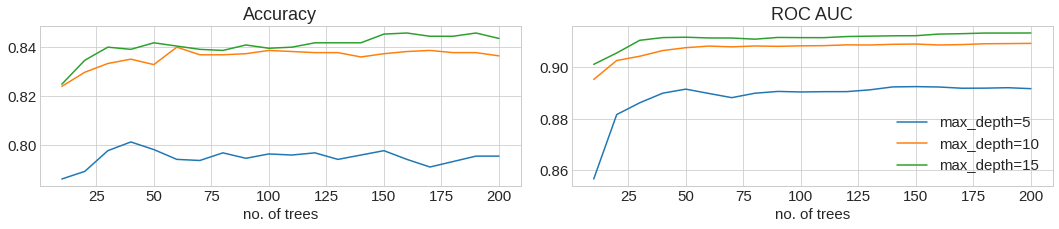

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
fig.tight_layout()

for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    axes[0].plot(df_subset.n_estimators, df_subset.acc,
             label='max_depth=%d' % d)
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('no. of trees')

    axes[1].plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
    axes[1].set_title('ROC AUC')
    axes[1].set_xlabel('no. of trees')

plt.legend()


In [31]:
# %%timeit it takes about 1min

if True:#False:
    max_depth = 15
    t=0.5

    RF_scores = []

    for s in [1, 3, 5, 10, 50]:
        for n in range(10, 201, 10):
            RF = RandomForestClassifier(n_estimators=n,
                                        max_depth=max_depth,
                                        min_samples_leaf=s,
                                        random_state=1)
            RF.fit(X_train, y_train)

            y_pred = RF.predict_proba(X_val)[:, 1]
            acc = accuracy_score(y_val, y_pred >= t)         
            auc = roc_auc_score(y_val, y_pred)

            RF_scores.append((s, n, acc, auc))

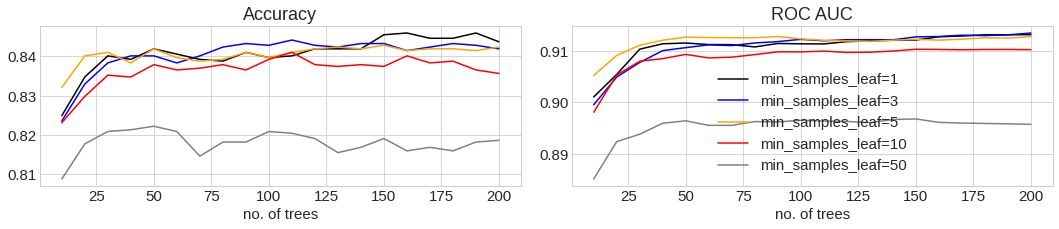

In [32]:
columns = ['min_samples_leaf', 'n_estimators', 'acc','auc']
df_scores = pd.DataFrame(RF_scores, columns=columns)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
fig.tight_layout()

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    axes[0].plot(df_subset.n_estimators, df_subset.acc,
             color=col,
             label='min_samples_leaf=%d' % s)
    axes[0].set_title('Accuracy')
    axes[0].set_xlabel('no. of trees')

    axes[1].plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
    axes[1].set_title('ROC AUC')
    axes[1].set_xlabel('no. of trees')

plt.legend()

The best parameters are:

In [33]:
n_estimators = 150
min_samples_leaf = 1
max_depth = 15
t=0.5

RF = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
RF.fit(X_train, y_train)

# TRAIN
y_pred = RF.predict_proba(X_train)[:, 1]
acc = accuracy_score(y_train, y_pred >= t) 
auc = roc_auc_score(y_train, y_pred)
print('For the training dataset:','ACC:', acc.round(3), 'ROC AUC:', auc.round(3))

# VAL
y_pred = RF.predict_proba(X_val)[:, 1]
RF_acc = accuracy_score(y_val, y_pred >= t) 
RF_auc = roc_auc_score(y_val, y_pred)
print('For the validation dataset:','ACC:', RF_acc.round(3), 'ROC AUC:', RF_auc.round(3))

For the training dataset: ACC: 0.965 ROC AUC: 0.996
For the validation dataset: ACC: 0.845 ROC AUC: 0.912


The performance on the training dataset is better than on the validation dataset, the model seems to overfit the target variable. Let us reduce the value of some parameters:

In [34]:
n_estimators = 125 #150
min_samples_leaf = 10 #3
max_depth = 10 #15
t=0.5

RF = RandomForestClassifier(n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
RF.fit(X_train, y_train)

# TRAIN
y_pred = RF.predict_proba(X_train)[:, 1]
acc = accuracy_score(y_train, y_pred >= t) 
auc = roc_auc_score(y_train, y_pred)
print('For the training dataset:','ACC:', acc.round(3), 'ROC AUC:', auc.round(3))

# VAL
y_pred = RF.predict_proba(X_val)[:, 1]
RF_acc = accuracy_score(y_val, y_pred >= t) 
RF_auc = roc_auc_score(y_val, y_pred)
print('For the validation dataset:','ACC:', RF_acc.round(3), 'ROC AUC:', RF_auc.round(3))

For the training dataset: ACC: 0.862 ROC AUC: 0.939
For the validation dataset: ACC: 0.836 ROC AUC: 0.907


Now the performance on the validation is similar than with the optimal parameters set, but it is closer to the performance on the training dataset.

### 3.5 XGBoost

Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting. Then, we will run an ensemble of trees but not in parallel, thus the next tree can learn from the previous tree.

In [35]:
features = numerical + dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/home/mmc/miniconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 6, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

# TRAIN
y_pred = model.predict(dtrain)
acc = accuracy_score(y_train, y_pred >= t) 
auc = roc_auc_score(y_train, y_pred)
print('For the training dataset:','ACC:', acc.round(3), 'ROC AUC:', auc.round(3))

# VAL
y_pred = model.predict(dval)
xgb_acc = accuracy_score(y_val, y_pred >= t) 
xgb_auc = roc_auc_score(y_val, y_pred)
print('For the validation dataset:','ACC:', xgb_acc.round(3), 'ROC AUC:', xgb_auc.round(3))

For the training dataset: ACC: 0.866 ROC AUC: 0.945
For the validation dataset: ACC: 0.829 ROC AUC: 0.907


Let us define the parameter ranges to find the best parameter values, first 'eta', then 'max_depth' and then
'min_child_weight'.

In [37]:
# performance monitoring: 
# after each round (i.e., after each new tree is trained) we inmediatly evaluate on the val dataset 
watchlist = [(dtrain, 'train'), (dval, 'val')]  

In [38]:
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)
# from the results in each round we can identify overfitting

[0]	train-auc:0.89739	val-auc:0.86772
[5]	train-auc:0.93068	val-auc:0.89887
[10]	train-auc:0.94675	val-auc:0.90827
[15]	train-auc:0.95566	val-auc:0.91295
[20]	train-auc:0.96082	val-auc:0.91482
[25]	train-auc:0.96830	val-auc:0.91720
[30]	train-auc:0.97215	val-auc:0.91746
[35]	train-auc:0.97606	val-auc:0.91914
[40]	train-auc:0.97970	val-auc:0.91976
[45]	train-auc:0.98252	val-auc:0.91910
[50]	train-auc:0.98465	val-auc:0.91942
[55]	train-auc:0.98574	val-auc:0.91941
[60]	train-auc:0.98717	val-auc:0.91912
[65]	train-auc:0.98954	val-auc:0.91960
[70]	train-auc:0.99038	val-auc:0.91900
[75]	train-auc:0.99240	val-auc:0.91923
[80]	train-auc:0.99336	val-auc:0.91906
[85]	train-auc:0.99426	val-auc:0.91881
[90]	train-auc:0.99463	val-auc:0.91817
[95]	train-auc:0.99527	val-auc:0.91784
[99]	train-auc:0.99557	val-auc:0.91802


In [39]:
xgb_params = {
    'eta': 0.1, #default is 0.3
    'max_depth': 6, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)

[0]	train-auc:0.89739	val-auc:0.86772
[5]	train-auc:0.91952	val-auc:0.88699
[10]	train-auc:0.92747	val-auc:0.89357
[15]	train-auc:0.93179	val-auc:0.89907
[20]	train-auc:0.93717	val-auc:0.90262
[25]	train-auc:0.94171	val-auc:0.90551
[30]	train-auc:0.94629	val-auc:0.90855
[35]	train-auc:0.94996	val-auc:0.91032
[40]	train-auc:0.95367	val-auc:0.91235
[45]	train-auc:0.95621	val-auc:0.91370
[50]	train-auc:0.95886	val-auc:0.91483
[55]	train-auc:0.96143	val-auc:0.91611
[60]	train-auc:0.96280	val-auc:0.91624
[65]	train-auc:0.96436	val-auc:0.91621
[70]	train-auc:0.96640	val-auc:0.91700
[75]	train-auc:0.96779	val-auc:0.91757
[80]	train-auc:0.97010	val-auc:0.91838
[85]	train-auc:0.97183	val-auc:0.91893
[90]	train-auc:0.97306	val-auc:0.91884
[95]	train-auc:0.97418	val-auc:0.91879
[99]	train-auc:0.97486	val-auc:0.91885


In [40]:
xgb_params = {
    'eta': 0.01, #default is 0.3
    'max_depth': 6, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)

[0]	train-auc:0.89739	val-auc:0.86772
[5]	train-auc:0.90336	val-auc:0.87591
[10]	train-auc:0.90708	val-auc:0.87902
[15]	train-auc:0.90846	val-auc:0.88074
[20]	train-auc:0.91202	val-auc:0.88251
[25]	train-auc:0.91260	val-auc:0.88251
[30]	train-auc:0.91474	val-auc:0.88531
[35]	train-auc:0.91524	val-auc:0.88560
[40]	train-auc:0.91626	val-auc:0.88649
[45]	train-auc:0.91747	val-auc:0.88683
[50]	train-auc:0.91877	val-auc:0.88806
[55]	train-auc:0.91991	val-auc:0.88896
[60]	train-auc:0.92098	val-auc:0.88965
[65]	train-auc:0.92154	val-auc:0.88985
[70]	train-auc:0.92231	val-auc:0.89058
[75]	train-auc:0.92273	val-auc:0.89069
[80]	train-auc:0.92327	val-auc:0.89086
[85]	train-auc:0.92386	val-auc:0.89118
[90]	train-auc:0.92472	val-auc:0.89205
[95]	train-auc:0.92571	val-auc:0.89303
[99]	train-auc:0.92637	val-auc:0.89367


With learnin grate 'eta = 0.1' in the round [50] we get 'train-auc:0.85489' and 'val-auc:0.77817', meaning that there is not so much overfitting and it is a reasonable good score. Let us tune the 'max_depth':

In [41]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 4, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)

[0]	train-auc:0.86834	val-auc:0.85045
[5]	train-auc:0.90635	val-auc:0.88688
[10]	train-auc:0.92465	val-auc:0.90281
[15]	train-auc:0.93333	val-auc:0.90755
[20]	train-auc:0.94012	val-auc:0.91135
[25]	train-auc:0.94462	val-auc:0.91423
[30]	train-auc:0.94823	val-auc:0.91539
[35]	train-auc:0.95154	val-auc:0.91660
[40]	train-auc:0.95433	val-auc:0.91869
[45]	train-auc:0.95579	val-auc:0.91856
[50]	train-auc:0.95898	val-auc:0.91988
[55]	train-auc:0.96201	val-auc:0.92099
[60]	train-auc:0.96422	val-auc:0.92068
[65]	train-auc:0.96591	val-auc:0.92105
[70]	train-auc:0.96779	val-auc:0.92129
[75]	train-auc:0.96888	val-auc:0.92097
[80]	train-auc:0.97052	val-auc:0.92012
[85]	train-auc:0.97183	val-auc:0.91983
[90]	train-auc:0.97319	val-auc:0.92044
[95]	train-auc:0.97496	val-auc:0.92023
[99]	train-auc:0.97605	val-auc:0.92020


In [42]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 3, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)

[0]	train-auc:0.83391	val-auc:0.81946
[5]	train-auc:0.89371	val-auc:0.87691
[10]	train-auc:0.90931	val-auc:0.89057
[15]	train-auc:0.91812	val-auc:0.89621
[20]	train-auc:0.92383	val-auc:0.90015
[25]	train-auc:0.92905	val-auc:0.90251
[30]	train-auc:0.93230	val-auc:0.90433
[35]	train-auc:0.93634	val-auc:0.90647
[40]	train-auc:0.93817	val-auc:0.90671
[45]	train-auc:0.94027	val-auc:0.90939
[50]	train-auc:0.94243	val-auc:0.91149
[55]	train-auc:0.94361	val-auc:0.91180
[60]	train-auc:0.94593	val-auc:0.91251
[65]	train-auc:0.94790	val-auc:0.91418
[70]	train-auc:0.94935	val-auc:0.91482
[75]	train-auc:0.95109	val-auc:0.91507
[80]	train-auc:0.95217	val-auc:0.91579
[85]	train-auc:0.95346	val-auc:0.91669
[90]	train-auc:0.95447	val-auc:0.91623
[95]	train-auc:0.95539	val-auc:0.91662
[99]	train-auc:0.95608	val-auc:0.91704


The best result with 'eta = 0.3' when varying 'max_depth' and avoiding overfitting seems to be 'max_depth=4' that in the round 25 gives 'train-auc: 0.9446' and 'val-auc: 0.9142'. Now we vary 'min_child_weight':

In [43]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 4, # default is 6
    'min_child_weight': 10, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)

[0]	train-auc:0.86729	val-auc:0.85248
[5]	train-auc:0.90153	val-auc:0.88480
[10]	train-auc:0.91636	val-auc:0.89896
[15]	train-auc:0.92561	val-auc:0.90594
[20]	train-auc:0.93288	val-auc:0.91151
[25]	train-auc:0.93757	val-auc:0.91539
[30]	train-auc:0.94072	val-auc:0.91711
[35]	train-auc:0.94335	val-auc:0.91941
[40]	train-auc:0.94668	val-auc:0.91991
[45]	train-auc:0.94872	val-auc:0.91973
[50]	train-auc:0.95129	val-auc:0.92081
[55]	train-auc:0.95288	val-auc:0.92072
[60]	train-auc:0.95419	val-auc:0.92099
[65]	train-auc:0.95562	val-auc:0.92101
[70]	train-auc:0.95613	val-auc:0.92094
[75]	train-auc:0.95727	val-auc:0.92084
[80]	train-auc:0.95854	val-auc:0.92080
[85]	train-auc:0.95958	val-auc:0.92036
[90]	train-auc:0.96103	val-auc:0.92065
[95]	train-auc:0.96193	val-auc:0.92059
[99]	train-auc:0.96284	val-auc:0.92036


In [44]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 4, # default is 6
    'min_child_weight': 30, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
# train the XGB
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                verbose_eval=5, # we print the evaluation every 5 trees/iterations
                evals=watchlist)
# apply to val
y_pred = model.predict(dval)

[0]	train-auc:0.86628	val-auc:0.84937
[5]	train-auc:0.89808	val-auc:0.87843
[10]	train-auc:0.91417	val-auc:0.89721
[15]	train-auc:0.92176	val-auc:0.90344
[20]	train-auc:0.92591	val-auc:0.90599
[25]	train-auc:0.92810	val-auc:0.90719
[30]	train-auc:0.93006	val-auc:0.90901
[35]	train-auc:0.93269	val-auc:0.91046
[40]	train-auc:0.93393	val-auc:0.91088
[45]	train-auc:0.93622	val-auc:0.91303
[50]	train-auc:0.93797	val-auc:0.91308
[55]	train-auc:0.93942	val-auc:0.91323
[60]	train-auc:0.94099	val-auc:0.91487
[65]	train-auc:0.94268	val-auc:0.91609
[70]	train-auc:0.94364	val-auc:0.91648
[75]	train-auc:0.94460	val-auc:0.91693
[80]	train-auc:0.94552	val-auc:0.91757
[85]	train-auc:0.94639	val-auc:0.91756
[90]	train-auc:0.94727	val-auc:0.91751
[95]	train-auc:0.94818	val-auc:0.91736
[99]	train-auc:0.94886	val-auc:0.91745


The default value 'min_child_weight = 1' gave the best results, in 25 rounds, both performances were high and similar: train-auc:0.94462 and val-auc:0.91423. Then, we select the following parameter set:

In [45]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 4, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=25)
y_pred = model.predict(dval)
xgb_auc =roc_auc_score(y_val, y_pred)
xgb_auc

0.9130920292645359

### 3.6 Model selection 

We will choose and train the final model.

In [46]:
print('Model performance ROC AUC on the validation dataset:')
print()
print('XGBoost', xgb_auc.round(3))
print('Random Forest', RF_auc.round(3))
print('Logistic Regresssion:', LR_auc.round(3))
print('Decission Tree Classifier:', DT_auc.round(3))

Model performance ROC AUC on the validation dataset:

XGBoost 0.913
Random Forest 0.907
Logistic Regresssion: 0.893
Decission Tree Classifier: 0.867


When we removed the feature 'duration' following the data provider recommendation (see the data descripcion above), we obtained the following ROC AUC on the validation dataset (the code is not shown here, to reproduce the results, uncomment the line where we deleted the 'duration' feature just before splitting):
+ XGBoost 0.781 ('eta': 0.1, 'max_depth': 4, 'min_child_weight': 1, and 70 rounds)
+ Random Forest 0.779 (same parameters than here)
+ Logistic Regresssion: 0.749
+ Decission Tree Classifier: 0.725 (same parameters than here).

**The best performer is XGBboost in both cases.** We continue with the analysis that includes all the features.

We train it on the 'full_train' dataset and test it on the test dataset with a k-fold cross validation. Let us prepare the full_train and test datasets:

In [47]:
# TRAIN
df_full_train = df_full_train.reset_index(drop=True) # reset index after splitting shuffling
y_full_train = df_full_train.deposit.values

#del df_full_train['deposit'] # remove target
    
full_train_dict = df_full_train[categorical].to_dict(orient='records')
X_full_train_cat = dv.fit_transform(full_train_dict) # encode the categorical features

X_full_train_num = df_full_train[numerical].values
X_full_train_num = scaler.fit_transform(X_full_train_num) # scale the numerical features

X_full_train = np.column_stack([X_full_train_num, X_full_train_cat]) # join the matrices

# TEST
df_test = df_test.reset_index(drop=True) # reset index after splitting shuffling
y_test = df_test.deposit.values

del df_test['deposit'] # remove target
    
test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) # encode the categorical features

X_test_num = df_test[numerical].values
X_test_num = scaler.transform(X_test_num) # scale the numerical features

X_test = np.column_stack([X_test_num, X_test_cat]) # join the matrices

Create the DMatrices for XGBoost

In [48]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=numerical + dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=numerical + dv.get_feature_names())

/home/mmc/miniconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Train and apply the model.

In [49]:
xgb_params = {
    'eta': 0.3, #default is 0.3
    'max_depth': 4, # default is 6
    'min_child_weight': 1, # default is 1
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc', # otherwise it uses logloss
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dfulltrain, num_boost_round=25)
y_pred = model.predict(dtest)
xgb_auc =roc_auc_score(y_test, y_pred)

In [50]:
xgb_auc

0.9192313256498048

The performance on the test dataset is good and similar to the previous performances on the training and validation datasets. Let us see if it is robust with a k-fold cross-validation: we evaluate the same model on different subsets of data (k-subsets, called fold) and we get the average prediction and the spread of the predictions. It is a powerful preventative measure against overfitting thus the model might be capable of generalization.

In [51]:
n_fold = 5
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
cv_results = xgb.cv(dtrain=dfulltrain, params=xgb_params, nfold=n_fold, num_boost_round=25,as_pandas=True,seed =1)
cv_results.iloc[-1] # results of the last xgb round

train-auc-mean    0.940732
train-auc-std     0.000883
test-auc-mean     0.919157
test-auc-std      0.004507
Name: 24, dtype: float64

The final model is quite stable. Let us save it.

## 4. Exporting to notebook to a python script

The logic for training the model is exported to a separate script:
+ in 'File', 'Download as', 'as Python (.py)' 

and then we save the trained model in the computer with pickle.

See the README.md of the [Github repo](https://github.com/MMdeCastro/ml-zoomcamp/tree/main/Midterm_project) for the next steps:
+ Model deployment with Flask
+ Dependency and enviroment management with pipenv*
+ Containerization with Docker
+ Cloud deployment